In [173]:
import math
import torch
import matplotlib.pyplot as plt

In [174]:
class JacobiDiffusionProcess():
    def __init__(self, s=1.0, a=1.0,b=1.0,device="cpu"):
        super(JacobiDiffusionProcess, self).__init__()
        
        self.s = s
        self.a = a
        self.b = b
        
        self.device = device
    
    def f(self,v):
        return 0.5*self.s*(self.a*(1-v)-self.b*v)
    
    def g(self,v):
        return torch.sqrt(self.s*v*(1-v))

In [178]:
def get_brownian(M=100,N=1000,D=1,T=1.0):

    t = torch.arange(N+1)/N # t=0,1/N,2/N,...,N/N
    dt = torch.tensor(T/N)
    dW = torch.sqrt(dt)*torch.randn(M,N,D)
    
    return t,dt,dW

def init(M=100,N=1000,D=1, x0=None,eps=1e-5):
    if x0 is None:
        V=torch.ones(M,N+1,D)-eps
        V[:int(M/2)] = eps
    else:
        V = x0*torch.ones(M,N+1,D) -eps*x0 + eps*(1-x0)
    return V

def clamp_step(v0, dt, dw, jdp):
    return torch.clamp(v0 + jdp.f(v0)*dt+ jdp.g(v0)*dw,min=0.0,max=1.0) 

def metro_step(v0, dt, dw, jdp):

    v1 = v0 + jdp.f(v0)*dt+ jdp.g(v0)*dw
    mask = (v1 > 0)*(v1 < 1) #mask is False for any entry outside of [0,1] 
    mask = ~mask #mask is True for any entry outside of [0,1] 
    while torch.any(mask):
        dw_new = torch.sqrt(dt)*torch.randn(dw[mask].shape)
        v1[mask] = v0[mask] + jdp.f(v0[mask])*dt+ jdp.g(v0[mask])*dw_new
        mask = ~((v1 > 0)*(v1 < 1)) #mask is True for any entry outside of [0,1] 
        
    return v1

def zero_dif_step(v0, dt, dw, jdp):
    mask = (v0>0.0)*(v0<1.0)
    dif = torch.zeros_like(v0)
    dif[mask] = jdp.g(v0[mask])
    return v0 + 5.0*jdp.f(v0)*dt+ dif*dw

def plot(t,X,name='Clamping'):
    plt.figure(figsize=(12, 8))
    for i in range(X.shape[0]):
            plt.plot(t,X[i,:,0])
    plt.title(name)
    plt.show()
    return

def compare_sampling(M=100, N=1000, D=1, T=1.0, s=1.0, a=1.0, b=1.0, eps=1e-5, x0=None):

    t,dt,dW = get_brownian(M=M,N=N,D=D,T=T)
    
    V_clamp = init(M=M,N=N,D=D, x0=x0,eps=eps)
    V_metro = init(M=M,N=N,D=D, x0=x0,eps=eps)
    V_zero = init(M=M,N=N,D=D, x0=x0,eps=eps)
    
    jdp = JacobiDiffusionProcess(s=s, a=a,b=b)
    
    v0_clamp = V_clamp[:,0,:]
    v0_metro = V_metro[:,0,:]
    v0_zero = V_zero[:,0,:]
    
    for i in range(N):
        
        v1_clamp = clamp_step(v0_clamp,dt,dW[:,i,:],jdp)
        v1_metro = metro_step(v0_metro,dt,dW[:,i,:],jdp)
        v1_zero = zero_dif_step(v0_zero,dt,dW[:,i,:],jdp)
        
        V_clamp[:,i+1] = v1_clamp
        V_metro[:,i+1] = v1_metro
        V_zero[:,i+1] = v1_zero
        
        v0_clamp = v1_clamp
        v0_metro = v1_metro
        v0_zero = v1_zero
        
    return t,V_clamp, V_metro, V_zero


############# Random Test ############
M= 10000
N= 1000
t,V_clamp, V_metro, V_zero = compare_sampling(M=M,N=N)

print('V_clamp.shape:', V_clamp.shape)
print('V_metro.shape:', V_metro.shape)

print('Clamping method has values outside of [0,1]',(V_clamp > 1).any() or (V_clamp < 0).any())
print('Metropolis method has values outside of [0,1]',(V_metro > 1).any() or (V_metro < 0).any())
print('Zero diffusion has values outside of [0,1]',(V_zero > 1).any() or (V_zero < 0).any())

#plot(t,V_clamp,name='Clamping')
#plot(t,V_metro,name='Metropolis')
#plot(t,V_zero,name='Zero Diffusion')

V_clamp.shape: torch.Size([10000, 1001, 1])
V_metro.shape: torch.Size([10000, 1001, 1])
Clamping method has values outside of [0,1] tensor(False)
Metropolis method has values outside of [0,1] tensor(False)
Zero diffusion has values outside of [0,1] tensor(True)


In [179]:
import seaborn as sns

/home/fe/nobis/anaconda3/envs/gfdm/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fe/nobis/anaconda3/envs/gfdm/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fe/nobis/anaconda3/envs/gfdm/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fe/nobis/anaconda3/envs/gfdm/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

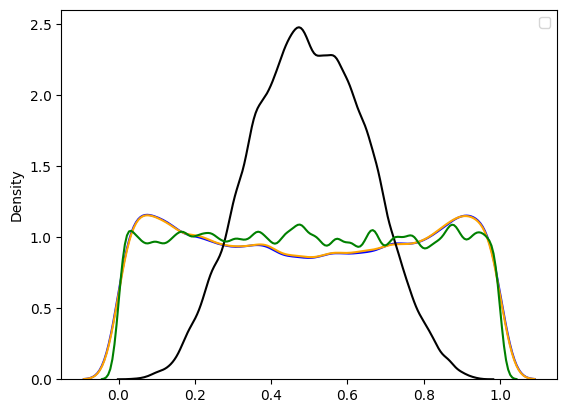

In [180]:
U = torch.rand(M)
sns.kdeplot(V_clamp[:, N, 0],bw_method=0.1,color='blue',legend='clamping')
sns.kdeplot(V_metro[:, N, 0],bw_method=0.1,color='orange',legend='metropolis')
sns.kdeplot(V_zero[:, N, 0],bw_method=0.1,color='black',legend='zero')
sns.kdeplot(U,bw_method=0.05,color='green',legend='uniform')
plt.legend()
plt.show()